In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dask.array as da
from distributed import Client
from fish.image.zds import ZDS
from os import makedirs
from os.path import exists
from functools import partial
from scipy.ndimage.filters import median_filter
from fish.util.distributed import get_jobqueue_cluster
from dask.array import coarsen
from skimage.io import imsave
import time
from scipy.interpolate import interp1d

import flika as flk
flk.start_flika()
from flika.window import Window as flw

Starting flika
Starting flika inside IPython


In [2]:
base_dirs = ('/nrs/ahrens/Yu/SPIM/20181014/fish1/20181014_1_2_doublehead_hucgc_gfaprgeco_6dpf_CLOnOff_20181014_130452/',
            '/nrs/ahrens/Yu/SPIM/20181014/fish1/20181014_1_2_doublehead_hucgc_gfaprgeco_6dpf_CLOnOff_20181014_130452/')

In [3]:
base_dir = base_dirs[0]
print(base_dir)
single_plane = False
dset = ZDS(base_dir + 'raw/', single_plane=single_plane)
data = dset.data
result = None
data.shape

/nrs/ahrens/Yu/SPIM/20181014/fish1/20181014_1_2_doublehead_hucgc_gfaprgeco_6dpf_CLOnOff_20181014_130452/


(801, 35, 2048, 2048)

In [6]:
exp_name = base_dir.split('/')[-2]
reg_dir = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}/'
ds_xy = 2
dff_movie_fname = f'{reg_dir}{exp_name}_dff_ds{ds_xy}.tif'
if not exists(reg_dir):
    makedirs(reg_dir)
reg_path = reg_dir + 'regparams_affine.npy'
anat_ref_fname = reg_dir + 'anat_ref.tif'
fs_im = dset.metadata['volume_rate']

roi = slice(100,800), slice(11, None), slice(None), slice(None)

if single_plane:
    fs_im *= dset.metadata['dimensions'][-1]
try:
    shifts = -np.load(reg_path)[:,:-1,-1]
except FileNotFoundError:
    print('affines not found, registration needs to be done')
    shifts = None
    data_filt = data.astype('float32').map_blocks(lambda v: median_filter(v, (1,1,5,5)), dtype='float32')
    mp = data.shape[0] // 2
    anat_ref = data_filt[slice(mp-5,mp+5)].mean(0).compute(scheduler='threads').astype('float32')
    imsave(anat_ref_fname, anat_ref)

In [7]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 60 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def reg(fixed, moving):
    from fish.image.alignment import estimate_translation
    from numpy import expand_dims
    affs =  estimate_translation(fixed.squeeze(), moving.squeeze()).affine
    return expand_dims(affs, 0)

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

In [6]:
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.111.12:42582 Dashboard: http://10.36.111.12:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
if shifts is None:
    reg_roi = (slice(None), slice(None), slice(None), slice(None))
    fig, axs = plt.subplots(ncols=2, figsize=(12,12))
    axs[0].imshow(anat_ref.max(0).squeeze(), clim=(100,200))
    axs[1].imshow(anat_ref[reg_roi[1:]].max(0).squeeze(), clim=(100,200))

In [8]:
%%time
if shifts is None:
    cluster.start_workers(300)
    ref_mx_bc = client.scatter(anat_ref[reg_roi[1:]].max(0), broadcast=True)
    data_filt = data[reg_roi].astype('float32').map_blocks(lambda v: median_filter(v, (1,1,5,5)), dtype='float32')
    if data_filt.shape[0] > 20000:
        ds_t = 4
        full_t = np.arange(data_filt.shape[0])
        affines_ds = da.map_blocks(reg, ref_mx_bc, data_filt[::ds_t].max(1), dtype='float32', chunks=(1,2,2)).compute()
        interper = interp1d(full_t[::ds_t], affines_ds, axis=0, bounds_error=False)
        affines = interper(full_t)        
    else:
        affines = da.map_blocks(reg, ref_mx_bc, data_filt.max(1), dtype='float32', chunks=(1,2,2)).compute()    
    np.save(reg_path, affines)
    shifts = -affines[:,:-1,-1]
    cluster.stop_all_jobs()

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 8.34 µs


Text(0, 0.5, 'Translation (um)')

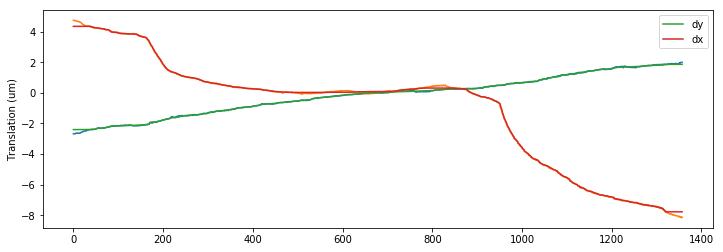

In [9]:
fig, axs = plt.subplots(figsize=(12,4))
um_per_pix = .40625
axs.plot(shifts * um_per_pix)
shifts_filt = median_filter(shifts, size=(150,1))
axs.plot(shifts_filt * um_per_pix)
axs.legend(axs.lines[2:], ['dy','dx'])
axs.set_ylabel('Translation (um)')

In [10]:
%%time
cluster.start_workers(10)
time.sleep(10)
shifts_filt_bc = client.scatter(shifts_filt[roi[0]])
medfilt = partial(median_filter, size=(1,1,3,3))
data_filt = data[roi].astype('float32').map_blocks(medfilt, dtype='float32')
data_tx = data_filt.map_blocks(shift_yx, shifts_filt_bc, dtype='float32')

data_ds = coarsen(np.mean, data_tx, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 'auto', 'auto','auto'))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

CPU times: user 694 ms, sys: 139 ms, total: 833 ms
Wall time: 11 s


In [11]:
%%time
cluster.start_workers(100)
result = data_dff.compute().squeeze()
time.sleep(10)
cluster.stop_all_jobs()

CPU times: user 4min 27s, sys: 5min 2s, total: 9min 29s
Wall time: 11min 13s


In [12]:
dff_movie_fname

'/groups/ahrens/ahrenslab/davis/tmp/20181014_1_2_doublehead_hucgc_gfaprgeco_6dpf_CLOnOff_20181014_130452/20181014_1_2_doublehead_hucgc_gfaprgeco_6dpf_CLOnOff_20181014_130452_dff_ds2.tif'

In [13]:
%%time
imsave(dff_movie_fname, result, imagej=True)

CPU times: user 4min, sys: 1min 34s, total: 5min 34s
Wall time: 4min 55s


/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1088: UserWarning: truncating ImageJ file
  warnings.warn("truncating ImageJ file")


In [19]:
from fish.util.plot import nparray_to_video, apply_cmap
from skimage.io import imread
from skimage.transform import downscale_local_mean
from moviepy.editor import ImageSequenceClip, VideoClip, concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.interpolate import interp1d

In [ ]:
dff = imread(dff_movie_fname)
anat_ref = downscale_local_mean(imread(anat_ref_fname)[roi[1:]], factors=(1,ds_xy, ds_xy))
anat_ref.shape

In [25]:
apply_cmap(anat_ref.max(0).clip(90,380))

(1024, 1024, 4)

In [47]:
sample = apply_cmap(dff[0].max(0))
composite_rgb = np.zeros((len(dff), *sample.shape), dtype=sample.dtype)
anat_rgb = apply_cmap(anat_ref.max(0).clip(90,380))

for t in range(composite_rgb.shape[0]): 
    dff_rgb = apply_cmap(dff[t].max(0).clip(.09, 1), cmap='inferno')
    composite_rgb[t] = (dff_rgb.astype('float') + anat_rgb.astype('float')).clip(0,255).astype('uint8')

In [54]:
clippy = ImageSequenceClip(sequence = list(composite_rgb), fps=30)
clippy.write_videofile('/groups/ahrens/ahrenslab/davis/tmp/tmp.mp4')